# Quantum Metric Learning

In this tutorial, we demonstrate training of quantum embedding (also known as quantum metric learning). This follows the protocols from the paper Quantum Embeddings for Machine Learning.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### 1. Data loading and processing

We start off by loading MNIST dataset. Divide the dataset by 255 to have value between 0 and 1.

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images, test_images = train_images / 255, test_images / 255

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [4]:
print(len(train_images))

60000


We classify only labels 0 and 1.

In [5]:
train_filter1 = np.where((train_labels == 0))
train_filter2 = np.where((train_labels == 1))

test_filter1 = np.where((test_labels == 0))
test_filter2 = np.where((test_labels == 1))

In [6]:
train_images_1, train_labels_1 = train_images[train_filter1], train_labels[train_filter1]
train_images_2, train_labels_2 = train_images[train_filter2], train_labels[train_filter2]
test_images_1, test_labels_1 = test_images[test_filter1], test_labels[test_filter1]
test_images_2, test_labels_2 = test_images[test_filter2], test_labels[test_filter2]

In [7]:
train_filter_tf = np.where((train_labels == 0) | (train_labels == 1))
test_filter_tf = np.where((test_labels == 0) | (test_labels == 1))

train_images_tf, train_labels_tf = train_images[train_filter_tf], train_labels[train_filter_tf]
test_images_tf, test_labels_tf = test_images[test_filter_tf], test_labels[test_filter_tf]

In [8]:
print("shape of training data: ", train_images_tf.shape)
print("length of training label: ", len(train_labels_tf))

shape of training data:  (12665, 28, 28, 1)
length of training label:  12665


### 2. Extracting features with Convolutional Neural Network

We use the technique from "Quantum Transfer Learning.ipynb". Use Convolutional Neural Network (CNN) to reduce 28 * 28 input data into 2 features.

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1))) # 26 x 26 x 32
model.add(layers.MaxPooling2D((2, 2)))  # 13 x 13 x 32
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

In [10]:
model.add(layers.Flatten())
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5

In [12]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

history = model.fit(train_images_tf, train_labels_tf, epochs = 10)

Epoch 1/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3255 - accuracy: 0.9926
Epoch 2/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3150 - accuracy: 0.9981
Epoch 3/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3143 - accuracy: 0.9990
Epoch 4/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3145 - accuracy: 0.9987
Epoch 5/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3143 - accuracy: 0.9989
Epoch 6/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3144 - accuracy: 0.9989
Epoch 7/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3150 - accuracy: 0.9982
Epoch 8/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3140 - accuracy: 0.9993
Epoch 9/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3139 - accuracy: 0.9994
Epoch 10/10
396/396 [==============================] - 5s 12ms/step - loss: 0.3149 - accura

In [13]:
extractor = keras.Model(inputs = model.inputs,
                        outputs = [layer.output for layer in model.layers])
features1 = extractor(train_images_1)
features2 = extractor(train_images_2)

In [16]:
print(len(features1))
features1[6]

8


<tf.Tensor: shape=(5923, 10), dtype=float32, numpy=
array([[52.35075 ,  0.      , 57.561512, ..., 48.316273,  0.      ,
         0.      ],
       [46.812553,  0.      , 54.77334 , ..., 46.489796,  0.      ,
         0.      ],
       [31.94197 ,  0.      , 35.747017, ..., 27.886847,  0.      ,
         0.      ],
       ...,
       [30.19295 ,  0.      , 32.78887 , ..., 28.425636,  0.      ,
         0.      ],
       [40.07914 ,  0.      , 42.131306, ..., 37.036163,  0.      ,
         0.      ],
       [34.572823,  0.      , 38.103077, ..., 32.73602 ,  0.      ,
         0.      ]], dtype=float32)>

In [ ]:
x1 = tf.constant(features1[6])
x2 = tf.constant(features2[6])

### 3. Quantum Embedding Circuits

In [17]:
def feature_encoding_hamiltonian(features, wires):
    for idx, w in enumerate(wires):
        qml.RX(features[idx], wires = w)

def ising_hamiltonian(weights, wires, l):
    qml.CNOT(wires = [wires[1], wires[0]])
    qml.RZ(weights[l,0], wires = wires[0])
    qml.CNOT(wires = [wires[1], wires[0]])    
    for idx, w in enumerate(wires):
        qml.RY(weights[l, idx + 1], wires = w)
        
def QAOAEmbedding(features, weights, wires):
    
    repeat = len(weights)
    for l in range(repeat):
        feature_encoding_hamiltonian(features, wires)
        ising_hamiltonian(weights, wires, 1)
    feature_encoding_hamiltonian(features, wires)

In [18]:
n_features = 2
n_qubits = 2 + n_features + 1

dev = qml.device("default.qubit", wires = n_qubits)

In [19]:
@qml.qnode(dev)
def swap_test(q_weights, x1, x2):
    
    QAOAEmbedding(features = x1, weights = q_weights, wires = [1,2])
    QAOAEmbedding(features = x2, weights = q_weights, wires = [3,4])
    
    qml.Hadamard(wires = 0)
    for k in range(n_features):
        qml.CSWAP(wires = [0, k + 1, 2 + k + 1])
    qml.Hadamard(wires = 0)
    
    return qml.expval(qml.PauliZ(0))

In [20]:
def overlaps(weights, X1 = None, X2 = None):
    
    linear_layer = weights[0]
    q_weights = weights[1]
    
    overlap = 0
    for x1 in X1:
        for x2 in X2:
            w_x1 = linear_layer @ x1
            w_x2 = linear_layer @ x2
            overlap += swap_test(q_weights, w_x1, w_x2)
    
    mean_overlap = overlap / (len(X1) * len(X2))
    return mean_overlap

In [21]:
def cost(weights, A = None, B = None):
    
    aa = overlaps(weights, X1 = A, X2 = A)
    bb = overlaps(weights, X1 = B, X2 = B)
    ab = overlaps(weights, X1 = A, X2 = B)
    
    d_hs = -2 * ab + (aa + ab)
    
    return 1 - 0.5 * d_hs

In [22]:
init_params_quantum = np.random.normal(loc = 0, scale = 0.1, size = (4,3))
init_params_classical = np.random.normal(loc = 0, scale = 0.1, size = (2, 10))

init_params = [init_params_classical, init_params_quantum]

In [23]:
from tensorflow import compat

In [24]:
tf.compat.v1.enable_eager_execution()

In [25]:
x1 = tf.constant(features1[6])
x2 = tf.constant(features2[6])

A = np.array(x1)
B = np.array(x2)

In [26]:
A = A[:100]
B = B[:100]

In [28]:
optimizer = qml.RMSPropOptimizer(stepsize = 0.01)
batch_size = 10
params = init_params

for i in range(100):
    
    selectA = np.random.choice(range(len(A)), size = (batch_size,), replace = True)
    selectB = np.random.choice(range(len(B)), size = (batch_size,), replace = True)
    
    A_batch = [A[s] for s in selectA]
    B_batch = [B[s] for s in selectB]
    
    params = optimizer.step(lambda w: cost(w, A = A_batch, B = B_batch), params)
    if i % 10 == 0:
        print("Steps ", i)

Steps  0
Steps  10
Steps  20
Steps  30
Steps  40
Steps  50
Steps  60
Steps  70
Steps  80
Steps  90


In [29]:
select = 100
A_B = np.r_[A[:select], B[:select]]

In [30]:
cost_before_train = cost(init_params, A = A[:select], B = B[:select])
cost_after_train = cost(params, A = A[:select], B = B[:select])

print("Cost before the train was: ", cost_before_train)
print("Cost after the train is: ", cost_after_train)

Cost before the train was:  0.9973659824207877
Cost after the train is:  0.9951794717706486


NameError: name 'make_axes_locatable' is not defined

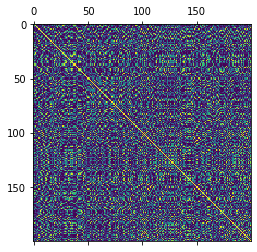

In [31]:
gram_before = [[overlaps(init_params, X1 = [x1], X2 = [x2]) for x1 in A_B] for x2 in A_B]

ax = plt.subplot(111)
im = ax.matshow(gram_before, vmin = 0, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.show()

In [ ]:
gram_after = [[overlaps(params, X1 = [x1], X2 = [x2]) for x1 in A_B] for x2 in A_B]

ax = plt.subplot(111)
im = ax.matshow(gram_after, vmin = 0, vmax = 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.show()